# Enunciado - Ej 4

In [57]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy import stats
from urllib.request import urlopen
from collections import defaultdict

pwd = os.getcwd()

#### Primer Item

In [3]:
# Carga de datos
colab_cient = nx.read_gml(pwd+'/Datos/netscience.gml')
red_internet = nx.read_gml(pwd+'/Datos/as-22july06.gml')

In [61]:
# Función auxiliar que devuelve un numpy array con todos los grados del grafo
get_degrees = lambda G: np.array([d for n, d in G.degree()])

def grado_vecinos(G):
    """
    INPUT: El grafo G.
    OUTPUT: Dos diccionarios, "grados" que contiene en valores a todos los grados de vecinos de un grado dado, y 
    "grado_med" es un diccionario con los grados como key y como valores el promedio de los grados de los vecinos
    de los nodos de esa key.
    """
    grados = defaultdict(list)
    grado_med = defaultdict()
    
    # En grados acumulamos los grados de todos los vecinos 
    for nodo, degree in G.degree():
        if G[nodo]:
            # Si tiene vecinos
            grados[degree] = grados[degree]+[d for n, d in G.degree(G[nodo])]
        else:
            pass
    
    for elem in grados.keys():
        grado_med[elem] = np.array(grados[elem]).mean()
    
    # Ploteamos
    plt.plot(pd.Series(grado_med))
    
    return grados, grado_med

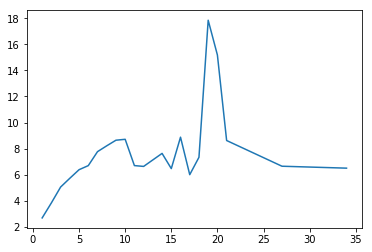

In [24]:
g1, grad_med_ciencia = grado_vecinos(colab_cient)

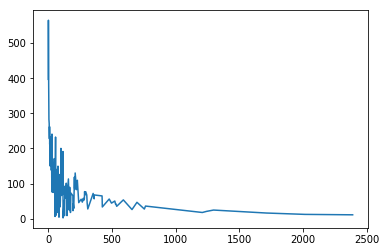

In [62]:
g2, grad_med_internet = grado_vecinos(red_internet)

#### Powerlaw fitting

Para realizar el fit del powerlaw, suponemos que la distribución es de la pinta $ k_{nn}(k) = \alpha  k^\mu $, entonces:

$\log(k_{nn}(k)) = \log(\alpha) + \mu \log(k)$

In [70]:
def estimacion_potencia(G, dist_grado_medio):
    
    """
    INPUT: El grafo G y la distribución media de grado, un diccionario que devuelve la funcion grado_vecinos.
    OUTPUT: Devuelve el valor del log alfa y log mu, y también plotea en escala logarítmica un scatter plot contra
    la regresión realizada, visualizando la varianza de los errores.
    """
    
    x = np.array(list(dist_grado_medio.keys()))
    y = np.array(list(dist_grado_medio.values()))
    datos = pd.DataFrame({'x':x, 'y':y})
    # Escalamos los valores
    x_log = np.log(datos.x)
    y_log = np.log(datos.y)
    
    # Calculamos el ajuste
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x_log, y_log)
    
    # Ploteamos
    plt.subplots_adjust(wspace = 0.6)
    powerlaw = lambda a, mu, x: a*x**mu
    
    plt.subplot(121)
    plt.plot(x, y, '*')
    plt.plot(x, powerlaw(np.exp(intercept), gradient, x), '+')
    plt.title('Distrubución de grado')
    plt.xlabel('Grados')
    plt.ylabel('Promedio de grado de vecinos')
    plt.grid(True)
    
    plt.subplot(122)
    plt.title('Distribución en escala logarítmica')
    sns.regplot(x = x_log, y = y_log)
    plt.xlabel('Log grados')
    plt.ylabel('Log promedio de grado de vecinos')
    plt.legend()
    
    return np.exp(gradient), np.exp(intercept)

(1.35814072578667, 3.556824179716342)

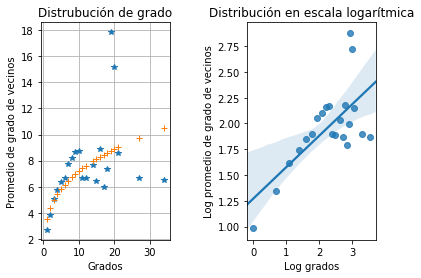

In [71]:
estimacion_potencia(colab_cient, grad_med_ciencia)

(0.64135410309006535, 559.82540878019017)

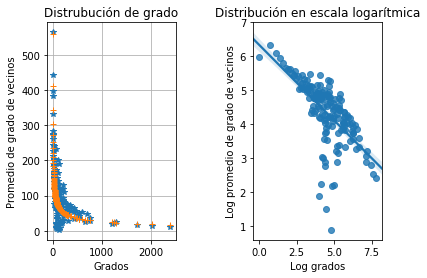

In [72]:
estimacion_potencia(red_internet, grad_med_internet)

### Asortatividad
Primero vamos a usar la función de asortatividad para ver si los cálculos que obtenemos a mano coinciden con los cálculos del paquete NetworkX. Para calcularlo vamos a usar las fórmulas 8.27 - 8.29 del libro de Newman.

In [96]:
def asortatividad(G):
    
    grados = get_degrees(G)
    
    # Calculamos los momentos
    S1 = grados.sum()
    S2 = (grados**2).sum()
    S3 = (grados**3).sum()
    
    S_e = 0
    for edge in G.edges():
        S_e += G.degree[edge[0]]*G.degree[edge[1]]
        
    r = (S1*2*S_e -S2**2)/(S1*S3 -S2**2)
    
    return r

In [102]:
asortatividad(colab_cient), nx.degree_assortativity_coefficient(colab_cient)

(0.4616224667525835, 0.46162246675258339)

In [103]:
asortatividad(red_internet), nx.degree_assortativity_coefficient(red_internet)

(-0.19838487512056477, -0.19838487512056457)